In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/amazon.zip"

Archive:  /content/drive/MyDrive/amazon.zip
  inflating: ratings_Beauty.csv      


## Часть I
### Система, основанная на популярности продукта, ориентированная на новых клиентов
* Ориентация на популярность - отличная стратегия для привлечения новых клиентов с помощью самых популярных продуктов, продаваемых на веб-сайте компании, и очень полезна для холодного запуска системы рекомендаций.

#### Импорт библиотек

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD

#### Загружаем датасет

In [5]:
amazon_ratings = pd.read_csv('ratings_Beauty.csv')
amazon_ratings = amazon_ratings.dropna()
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [6]:
amazon_ratings.shape

(2023070, 4)

In [7]:
popular_products = pd.DataFrame(amazon_ratings.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


<Axes: xlabel='ProductId'>

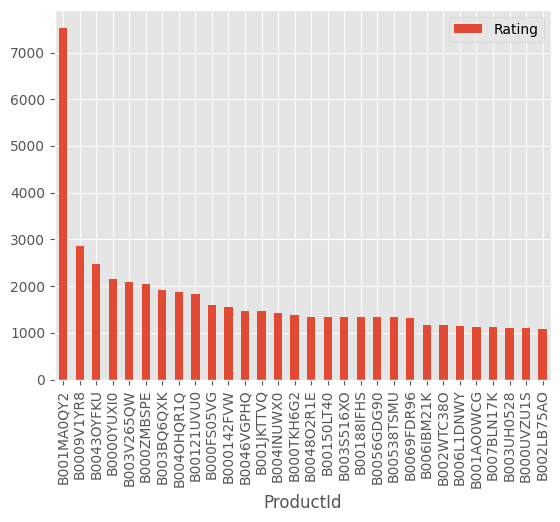

In [8]:
most_popular.head(30).plot(kind = "bar")

**Анализ:**

* График выше показывает популярные товары(отсортированные в порядке невозрастания).

* Например, товар с ID B001MA0QY2 имеет более 7000 продаж, следующий по популярности товар, имеющий ID B0009V1YR8, был продан в кол-ве около 3000, и тд.     

## Часть II
### Система коллаборативной фильтрации

* Рекомендуем товары клиентам, опираясь на их предыдущие покупки и схожесть оценок с другими покупателями, которые приобрели аналогичные товары, и сравниваем эти оценки с оценками этого конкретного клиента.
* Метод коллаборативной фильтрации здесь подходит, поскольку он помогает прогнозировать продукты для конкретного пользователя, выявляя закономерности на основе предпочтений из множества пользовательских данных.

#### Матрица полезности, основанная на проданных продуктах и отзывах пользователей
**Матрица полезности:** Матрица полезности состоит из всех возможных сведений о предпочтениях пользователя (рейтингах товаров), представленных в виде матрицы. Матрица полезности будет разреженной, поскольку ни один из пользователей не купил бы все товары в списке, следовательно, большинство значений неизвестны.

In [37]:
# Подматрица из 10000 строк

amazon_ratings1 = amazon_ratings.sample(10000)

In [38]:
ratings_utility_matrix = amazon_ratings1.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_utility_matrix.head()

ProductId,5357956111,7535842801,9788071198,9790775261,979078127X,9790798075,9790799829,9790801645,B000007T5X,B000026G2H,...,B00KJRWVYC,B00KKVHRW8,B00KTP8Q1G,B00KVE7R0Q,B00KVO2JWC,B00KWFDBKE,B00KXG8JF4,B00L3LB0IG,B00L5JHZJO,B00L5KTZ0K
UserId,,,,,,,,,,,,,,,,,,,,,
A01254332UU57MKWKP4VI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0334811544NRL0EPZY7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03765451LCS41DO5OQ2W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03900532XT2E5T10WV0U,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A04134883ETL5G3LIIJI1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Как и ожидалось, матрица получилась разреженной. Пустые ячейки заполнены нулями

In [39]:
ratings_utility_matrix.shape

(9918, 8202)

Транспонирование матрицы

In [40]:
X = ratings_utility_matrix.T
X.head()

UserId,A01254332UU57MKWKP4VI,A0334811544NRL0EPZY7,A03765451LCS41DO5OQ2W,A03900532XT2E5T10WV0U,A04134883ETL5G3LIIJI1,A06044653363P2MNZ6HFH,A07250671O6OIEHFZ14RQ,A072629938188J5Z3FJAG,A0903581294IP0V6FDJK9,A092783026OHH7DS8E8DE,...,AZVJ79JI2LIA3,AZVUBJ1OXBEYU,AZW7FIUDPE2L8,AZWSGSUAZXMGY,AZX5U35YDZZXI,AZXQPIXY08NLU,AZY3Z9QI0G8L,AZY6YGENLUE4O,AZYRUWYE4ZLPT,AZZT1ERHBSNQ8
ProductId,,,,,,,,,,,,,,,,,,,,,
5357956111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7535842801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9788071198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9790775261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
979078127X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
X.shape

(8202, 9918)

In [42]:
X1 = X

### Сингулярное разложение матрицы

In [43]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
print(decomposed_matrix.shape)
decomposed_matrix

(8202, 10)


array([[-3.59022986e-09,  2.45466140e-07,  5.08839028e-07, ...,
         9.76416854e-06,  1.23857356e-05,  7.85755740e-06],
       [ 5.86639839e-09, -3.35733002e-07, -1.62907901e-06, ...,
        -7.87237905e-06, -1.63549230e-06, -1.71579569e-05],
       [-7.85972181e-10,  4.52230943e-07,  2.32281785e-06, ...,
        -3.98851966e-06, -1.26942189e-05, -4.48572105e-06],
       ...,
       [-1.56884969e-10,  4.56308170e-07, -4.23729082e-07, ...,
        -5.53726541e-06, -3.39612554e-05,  2.37775705e-05],
       [ 1.24315960e-09, -9.46214849e-07,  1.21706814e-06, ...,
        -4.33990290e-05, -3.37202353e-05,  2.03285706e-05],
       [ 1.64318955e-09, -1.23245713e-07, -5.29439226e-06, ...,
         4.52397577e-06,  6.72662306e-06,  1.11859460e-05]])

### Корреляционная матрица

In [44]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(8202, 8202)

In [45]:
correlation_matrix

array([[ 1.        , -0.16502168, -0.35244222, ..., -0.44736498,
        -0.30428829, -0.09150983],
       [-0.16502168,  1.        , -0.51617095, ..., -0.62960485,
        -0.09312213, -0.72826918],
       [-0.35244222, -0.51617095,  1.        , ...,  0.58803795,
         0.37551515,  0.06339026],
       ...,
       [-0.44736498, -0.62960485,  0.58803795, ...,  1.        ,
         0.57947407,  0.49022346],
       [-0.30428829, -0.09312213,  0.37551515, ...,  0.57947407,
         1.        , -0.14140617],
       [-0.09150983, -0.72826918,  0.06339026, ...,  0.49022346,
        -0.14140617,  1.        ]])

<Axes: >

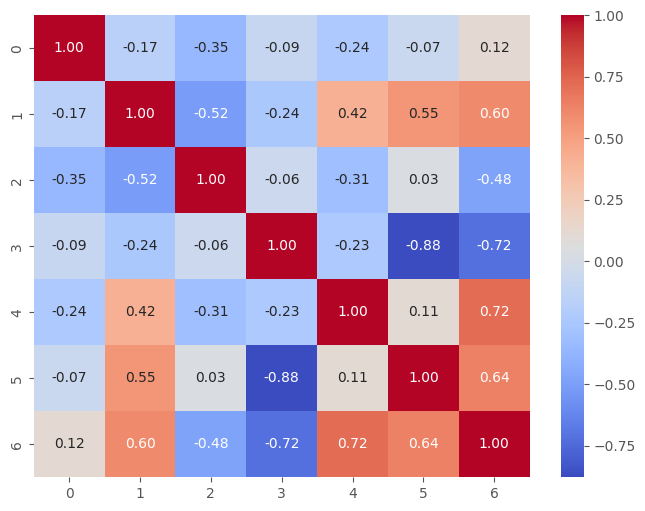

In [74]:
import seaborn as sns
subset_matrix = correlation_matrix[0:7, 0:7]

plt.figure(figsize=(8, 6))
sns.heatmap(subset_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=range(0, 7),
            yticklabels=range(0, 7))

### Выделяем товар с ID B0000535V0 из матрицы

Предположим, что клиент покупает товар с ID B0000535V0(выбран случайно)

In [46]:
X.index[52]

'B0000535V0'

In [48]:
i = "B0000535V0"

product_ids = list(X.index)
product_ID = product_ids.index(i)
product_ID

52

Корреляция для всех товаров с товаром, приобретенным этим клиентом, на основе товаров, оцененных другими покупателями, которые купили тот же товар

In [49]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(8202,)

In [51]:
correlation_product_ID

array([-0.20119099,  0.06888601,  0.69877359, ...,  0.22625794,
        0.58534337, -0.56974304])

### Рекомендуем топ 10 самых коррелирующих товаров

In [50]:
Recommend = list(X.index[correlation_product_ID > 0.90])

# Убираем уже купленный товар
Recommend.remove(i)

Recommend[0:9]

['B00008CMOQ',
 'B000GI3U6C',
 'B000PSTJ4K',
 'B0015KQUO4',
 'B001A6K9NG',
 'B001ET79H8',
 'B0032C6F20',
 'B0037STKW6',
 'B004C1101G']

Мы получили топ-10 товаров для отображения рекомендательной системой пользователю, основываясь на истории покупок других пользователей сайта.

## Часть III
* Для бизнеса без какой-либо истории покупок может быть импользованна рекомендательная система, основанная на поисковых движках. Рекомендации товаров могут быть основаны на текстовом анализе описания продукта

In [54]:
!unzip "/content/drive/MyDrive/product_descriptions.zip"

Archive:  /content/drive/MyDrive/product_descriptions.zip
  inflating: product_descriptions.csv  


In [59]:
# Импорт библиотек

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

### "Item-to-item" рекомендательная система, основанная на описании продукта

In [55]:
product_descriptions = pd.read_csv('product_descriptions.csv')
product_descriptions.shape

(124428, 2)

#### Убираем пустые значения

In [56]:
product_descriptions = product_descriptions.dropna()
product_descriptions.shape
product_descriptions.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [57]:
product_descriptions1 = product_descriptions.head(500)

product_descriptions1["product_description"].head(10)

0    Not only do angles make joints stronger, they ...
1    BEHR Premium Textured DECKOVER is an innovativ...
2    Classic architecture meets contemporary design...
3    The Grape Solar 265-Watt Polycrystalline PV So...
4    Update your bathroom with the Delta Vero Singl...
5    Achieving delicious results is almost effortle...
6    The Quantum Adjustable 2-Light LED Black Emerg...
7    The Teks #10 x 1-1/2 in. Zinc-Plated Steel Was...
8    Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...
9    Valley View Industries Metal Stakes (4-Pack) a...
Name: product_description, dtype: object

#### Выбираем признаки из описания

Преобразуем текст в вектор

In [60]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(product_descriptions1["product_description"])
X1

<500x8932 sparse matrix of type '<class 'numpy.float64'>'
	with 34817 stored elements in Compressed Sparse Row format>

#### Визуализируем кластеры товаров

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


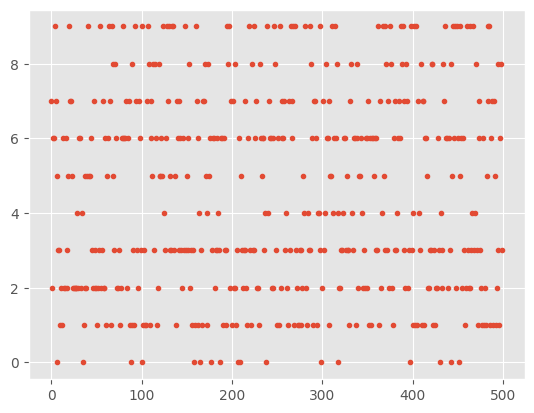

In [61]:
X=X1

kmeans = KMeans(n_clusters = 10, init='k-means++')
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

In [62]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

## Вывод
* Рекомендация товара, основываясь на уже выбранном клиентом товаре.
* Рекомендация сопутствующего товара на основе "часто покупаемых вместе".

#### Топ слов в каждом кластере, основываясь на описании товара

In [64]:
true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print_cluster(i)

Top terms per cluster:
Cluster 0:
 power
 cutting
 volt
 saw
 tool
 battery
 amp
 lithium
 motor
 m12
Cluster 1:
 water
 toilet
 heater
 warranty
 year
 easy
 tank
 design
 gal
 flush
Cluster 2:
 light
 nickel
 watt
 finish
 bulb
 home
 fan
 bay
 fixture
 white
Cluster 3:
 air
 cooling
 window
 drop
 ball
 water
 cool
 helps
 design
 brass
Cluster 4:
 brush
 roller
 pet
 dust
 easy
 paint
 dog
 ft
 cleaning
 tool
Cluster 5:
 lbs
 storage
 shelves
 easy
 wall
 adjustable
 finish
 commercial
 unit
 shelf
Cluster 6:
 metal
 steel
 screw
 screws
 gauge
 drill
 hole
 work
 door
 design
Cluster 7:
 wood
 ft
 concrete
 landscape
 vary
 product
 store
 used
 natural
 stake
Cluster 8:
 cycle
 oven
 cooking
 steam
 moisture
 wash
 ft
 cu
 dry
 easy
Cluster 9:
 post
 painted
 wood
 rail
 ft
 moulding
 primed
 used
 base
 fence


#### Предсказываем кластеры, основываясь на ключевых поисковых словах

In [67]:
def show_recommendations(product):
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    print_cluster(prediction[0])

* **Ключевое слово:** cutting tool

In [66]:
show_recommendations("cutting tool")

Cluster 0:
 power
 cutting
 volt
 saw
 tool
 battery
 amp
 lithium
 motor
 m12


* **Ключевое слово:** spray paint

In [68]:
show_recommendations("spray paint")

Cluster 4:
 brush
 roller
 pet
 dust
 easy
 paint
 dog
 ft
 cleaning
 tool


* **Ключевое слово:** steel drill

In [69]:
show_recommendations("steel drill")

Cluster 6:
 metal
 steel
 screw
 screws
 gauge
 drill
 hole
 work
 door
 design


В случае, если слово появляется в нескольких кластерах, алгоритм выбирает кластер с наивысшей частотой появления слова.

* **Ключевое слово:** water

In [70]:
show_recommendations("water")

Cluster 1:
 water
 toilet
 heater
 warranty
 year
 easy
 tank
 design
 gal
 flush


Когда кластер определен, рекомендательная система может отобразить товары из соответствующего кластера, основанного на описании товара.

#### Результаты:

Это лучше всего работает, если компания впервые настраивает свой веб-сайт электронной коммерции и у нее изначально нет истории покупок/оценок товаров пользователями. Эта система рекомендаций поможет пользователям получить хорошую рекомендацию в начале, и как только у покупателей появится история покупок, механизм рекомендаций сможет использовать метод коллаборативной фильтрации.